# Receiver Simulations

Simulating backscatter retrievals up to cloud boundaries. The simulations will include signals for high- and low-gain channels. The flux will follow the theory from 'photon_budget_calculation.ipynb'. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time
import xarray as xr
import pickle

# import library for simulating Poisson point processes
cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import sim_deadtime_utils as sim
from load_ARSENL_data import set_binwidth

eps = sys.float_info.epsilon

In [2]:
# Constants

c = 299792458  # [m/s] speed of light
k_B = 1.380649e-23  # [m^2 kg s-2 K-1]
g_0 = 9.81  # [m s-2] Gravity
M_air = 28.97  # [g/mol] Molar mass of air
R_0 = 8.314459  # [J/mol/K] Universal gas constant
N_A = 6.022e23  # [atoms / mol] Avogadro's number
h = 6.626e-34  # [J s] Planck's constant

L = 9e-3  # [K/km] Temperature lapse rate for Denver
P_0 = 1000  # [mbar] Typical absolute pressure for Denver
T_0 = 294.3  # [K] Typical 70 F temperature for Denver
lamb = 532.18e-9  # [m] laser wavelength

D = 16  # [in] outer diameter of telescope
d = 5  # [in] inner diameter of telescope

dt_TCSPC = 25e-12  # [s] native resolution of TCSPC

P_L = 35e-3  # [W] average laser power
dt_L = 700e-12  # [s] laser pulse FWHM

# Receiver specs (at 532 nm)
R_tele = 0.95  # Telescope reflectance
R_M = 0.99  # Folding mirror reflectance
T_L = 0.9  # Standard lens transmittance
mu_F = 0.994  # [m-1] Fiber transmission coefficient
L_F = 2  # [m] Fiber length
T_F = mu_F * L_F  # Fiber transmittance
T_FC = T_L  # Fiber coupler transmittance
T_BS_LG = 0.01  # Beam-splitter low-gain transmittance
T_BS_HG = 0.99  # Beam-splitter high-gain transmittance
T_SBF = 0.9  # Solar background filter transmittance
eta_QE = 0.5  # Detector quantum efficiency

dalt = c * dt_TCSPC / 2  # [m]
alt = np.arange(eps, 10e3, dalt)  # [m] target range

### Molecular Signal

The molecular signal will serve as the background Rayleigh scattering. The aerosol signal (clouds) will follow.

In [3]:
# Calculate Temperature and Pressure
T = T_0 - L/1000*alt  # [K]

C_g = g_0*M_air/R_0/L
P = P_0 * (T/T_0)**C_g  # [mbar]

# Scattering coefficients
beta_mol = 2.938e-32 * P/T * lamb**(-4.0117)  # [m-1 sr-1]
alpha_mol = 8*np.pi/3 * beta_mol  # [m-1]

# Telescope parameters
A = np.pi/4*(D**2-d**2)  # [in^2]
A *= (0.0254**2)  # [m^2] Area

# Geometric overlap
# G = 1  # assumed one at furthest range
# Choose reasonable inverted exponential for asymptotic rise to 1 at some altitude
G_alt = np.arange(-500, 9500, dalt)
alpha = 0.05  # Time constant for exponential
G = (1 / (1+np.exp(-alpha*G_alt)))
# G = np.concatenate((G, np.ones(len(alt)-len(G_alt))))

# Range resolution
dR = c * dt_TCSPC / 2  # [m]

# Number of transmitted photons per shot
N_L = P_L*dt_L/h/c*lamb

# Receiver efficiency
eta_LG = R_tele * R_M * T_L**4 * T_F * T_FC**2 * T_BS_LG * T_SBF * eta_QE
eta_HG = R_tele * R_M * T_L**4 * T_F * T_FC**2 * T_BS_HG * T_SBF * eta_QE

# Background signal
N_B = 0  # number of background photons

# Generate photon-count expectation function

# Lidar equation for molecular backscatter
R = alt  # [m] assume transmitter and receiver are at the surface

trans = np.exp(-np.cumsum(alpha_mol*dR))

N_mol_LG = N_L*beta_mol*dR*A/R**2*trans**2*eta_LG*G + N_B
N_mol_HG = N_L*beta_mol*dR*A/R**2*trans**2*eta_HG*G + N_B

# Remove first term (unreal, 0 km alt)
N_mol_LG[0] = 0
N_mol_HG[0] = 0

N_mol_LG_tot = np.sum(N_mol_LG)
N_mol_HG_tot = np.sum(N_mol_HG)

print('Total low gain photons: {:.2E}'.format(N_mol_LG_tot))
print('Total high gain photons: {:.2E}'.format(N_mol_HG_tot))

Total low gain photons: 7.95E-05
Total high gain photons: 7.87E-03


### Generate simulated returns

Using Matt's code (same one I used for my deadtime experiments), generate simulated measurements using the arrival-rate function generated.

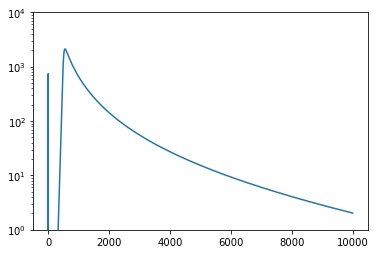

In [28]:
plt.semilogy(alt, N_mol_HG/dt_TCSPC)
plt.ylim([1, 10000])
# plt.plot(alt, G)
plt.show()

In [23]:
# Make sure to look into changing window bounds before starting!
checked = False

if checked:
    """
    Using Matthew Hayman's 'photon_count_generator' method in 'sim_deadtime_utils', generate simulated data with
    and without deadtime effects.
    :param t_sim_max: (float) maximum time for each laser shot [s]
    :param dt_sim: (float) resolution settings [s]
    :param tD: (float) deadtime [s]
    :param Nshot: (int) number of laser shots
    :param wrap_deadtime: (bool) set TRUE to wrap deadtime into next shot if detection is close to 't_sim_max'
    :param window_bnd: (1x2 float list) time bounds on simulation [s]
    :param rho_func: (1xlen(t_sim)) arrival-rate function [Hz]
    :return: flight_time, true_flight_time, n_shots, t_det_lst, t_phot_lst
    """

    dt_sim = dt_TCSPC  # [s]
    rho_func = N_mol_HG / dt_sim * 10 # [Hz] arrival-rate function (flux)
    Nshot = 5000
    tD = 29.1  # [s] Deadtime interval
    wrap_deadtime = False

    ##### GENERATE SIMULATED DATA #####

    # simulation resolution settings
    if type(Nshot) != int:
        Nshot = int(Nshot)  # number of laser shots

    # generate the simulated scene time axis
    # t_sim = np.arange(t_sim_min, t_sim_max, dt_sim)           # simulation time
    # R[0] = 0
    t_sim = R/c*2  # [s] simulation time
    t_sim_bins = np.concatenate((t_sim, t_sim[-1:]+dt_sim))  # simulation time histogram bins
    t_sim_bins[0] = 0

    # generate the photon arrival rate of the profile
    photon_rate_arr = rho_func  # [Hz]

    # generate photon counts

    # lists of photon arrivals per laser shot
    start = time.time()
    t_det_lst = []  # detected photons (includes deadtime)
    t_phot_lst = []  # actual photons (no dead time)
    sync_idx = np.arange(Nshot)  # sync value
    det_sync_idx = []
    phot_sync_idx = []
    det_events = []
    phot_events = []

    t_det_last = -100.0  # last photon detection event
    for n in range(Nshot):
        # simulate a laser shot
        ptime, ctime = sim.photon_count_generator(t_sim_bins, photon_rate_arr, tau_d_flt=tD, last_photon_flt=t_det_last)
        if wrap_deadtime:
            if len(ctime) > 0:
                t_det_last = ctime[-1]
            t_det_last -= t_sim_bins[-1]

    #     print(ctime)
    #     print(ptime)

        ctime /= dt_sim  # convert from s to clock counts since sync event
        ptime /= dt_sim  # convert from s to clock counts since sync event

        for i in range(len(ctime)):
            det_events.append(ctime[i])  # detection time tags
            det_sync_idx.append(n)
        for i in range(len(ptime)):
            phot_events.append(ptime[i])  # photon time tags
            phot_sync_idx.append(n)

    det_idx = np.arange(len(det_events))
    phot_idx = np.arange(len(phot_events))

7.648472582869129e-06
4.4070356684967735e-06
5.992825949202464e-06
3.4565696432671446e-06
4.9511078788048404e-06
8.629688298837783e-06
7.689337158470981e-06
1.3210914118296077e-05
3.492898166688594e-06
7.031951737649736e-06
4.918895705522165e-06
3.378993492115975e-06
1.1472012360185933e-05
3.5743753869513767e-06
3.7940230550256807e-06
5.309075390797147e-06
5.118843070396996e-06
1.2533388353481968e-05
6.7973974820050495e-06
8.972951853831653e-06
4.621983528357881e-06
4.846142995135094e-06
2.4162129244990974e-05
1.4938157265153648e-05
1.6664142608746286e-05
1.9718680524547948e-05
5.559622114487017e-06
8.538176582923805e-06
1.0696132269578552e-05
5.603944985847486e-06
4.3923545400589886e-06
5.017280501541119e-06
3.1661347529457215e-06
3.992579324908631e-06
4.35277077229366e-06
5.638082812286696e-06
8.607619616548968e-06
6.102506334494138e-06
6.3669039868017665e-06
1.0819177233359832e-05
3.0150042255089634e-06
4.874127021780504e-05
1.547486672856376e-05
3.614364735409483e-06
1.481813025200

6.265180805472369e-06
9.656045054694896e-06
3.248874640134891e-06
4.531736128595393e-06
4.419792898189756e-06
6.43785592643962e-06
6.904189908089956e-06
4.012633652316766e-06
3.960003829341095e-06
7.806498267702093e-06
6.084822492972663e-06
5.02315653734518e-06
6.136553498429041e-05
9.672418069225487e-06
6.630930447533344e-06
3.7467827272924085e-06
4.312444252986168e-05
1.301850143193404e-05
3.7829088832944083e-06
5.70478144749588e-06
3.1089335222819356e-06


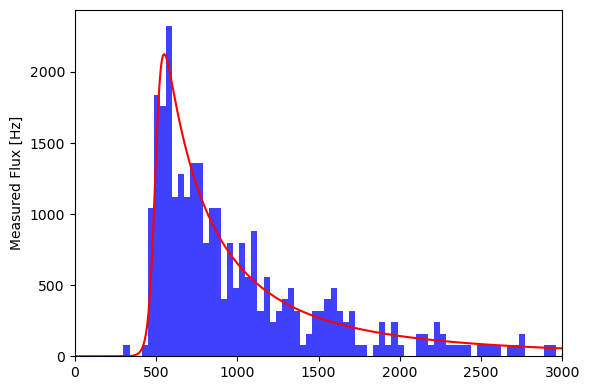

In [59]:
tof = (np.array(det_events)*dt_sim)
r_meas = tof * c

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
n, bins = np.histogram(tof, bins=t_sim_bins[::10000])
binwidth = np.diff(bins)[0]
N = n / binwidth / Nshot  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center*c/2, N/10, align='center', width=binwidth*c/2, color='b', alpha=0.75)
ax.plot(t_sim*c/2, N_mol_HG/dt_TCSPC, 'r')
ax.set_ylabel('Measured Flux [Hz]')
# ax.set_yscale('log')
ax.set_xlim([0, 3e3])
plt.tight_layout()
plt.show()
# ax3.set_xlim([window_bnd[0], window_bnd[1]])